# **Анализ эффективности рекламной кампании HR-проекта (поиск инсайтов, составление рекомендаций стейкхолдерам)**

Дипломная работа Масловой Татьяны, DA-66

In [ ]:
pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import squarify

# Описание исходных данных, их подготовка и преобразование


## Данные из CRM

In [ ]:
crm = pd.read_csv('1 CRM.csv', sep=',', encoding='utf-8')
crm.head()

,ID,Повторное обращение,Конечный статус,Контакт,Запись на собеседование,Источник,Сделка закрыта,Дата создания,UTM Source,UTM Medium,UTM Campaign,UTM Content
0,4368,N,Не подходит,Лид #4368,нет,jivo,да,30.04.2021 4:47:15,yandex,NaN,NaN,NaN
1,4364,N,Нет ответа,Владислав,нет,NaN,да,26.04.2021 18:41:02,NaN,NaN,NaN,NaN
2,4358,N,Нет ответа,Сергей,нет,NaN,да,24.04.2021 14:21:17,Google,search,(organic),NaN
3,4356,N,Отказалась модель,Анастасия,нет,NaN,да,21.04.2021 17:47:12,NaN,NaN,NaN,NaN
4,4346,N,Отказалась модель,Ольга,нет,NaN,да,16.04.2021 14:13:32,Yandex,search,(organic),NaN


In [ ]:
crm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       1220 non-null   int64 
 1   Повторное обращение      1220 non-null   object
 2   Конечный статус          1220 non-null   object
 3   Контакт                  1220 non-null   object
 4   Запись на собеседование  1220 non-null   object
 5   Источник                 629 non-null    object
 6   Сделка закрыта           1220 non-null   object
 7   Дата создания            1220 non-null   object
 8   UTM Source               596 non-null    object
 9   UTM Medium               319 non-null    object
 10  UTM Campaign             284 non-null    object
 11  UTM Content              263 non-null    object
dtypes: int64(1), object(11)
memory usage: 114.5+ KB


Опишем столбцы в таблице:

* ID - id обращения/контакта/лида.

* Повторное обращение  - crm фиксирует по номеру телефона это первичное (N) или повторное обращение (Y).

* Конечный статус - конечный статус заявки после завершения работы с ней.

* Контакт - имя контакта, которое оставляют люди или присваивает система.

* Запись на собеседование  - промежуточный статус, отмечающий, была ли запись на собеседование.

* Источник  - площадка, с которой пришло обращение.

* Сделка закрыта - статус, подтверждающий, что работа с обращением закрыта.

* Дата создания - дата и время обращения.

* UTM Source - utm-метка рекламной кампании, отмечает канал.

* UTM Medium - utm-метка рекламной кампании, отмечает тип рекламы.

* UTM Campaign - utm-метка рекламной кампании, отмечает кампанию в канале.

* UTM Content - utm-метка рекламной кампании, отмечает объявление в кампании.
   

In [ ]:
# Не заполнены строки в столбцах Источник, а также в столбцах по utm-меткам.
# Сначала заполним данные в Источнике, из рабочей записки мы знаем, что по умолчанию это значение основной сайт
crm['Источник'].unique()

array(['jivo', nan, 'mini', 'marquiz', 'Звонок', 'Электронная почта',
       'Сервис Conversus.pro'], dtype=object)

In [ ]:
crm['Источник'] = crm['Источник'].fillna('Сайт')
crm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       1220 non-null   int64         
 1   Повторное обращение      1220 non-null   object        
 2   Конечный статус          1220 non-null   object        
 3   Контакт                  1220 non-null   object        
 4   Запись на собеседование  1220 non-null   object        
 5   Источник                 1220 non-null   object        
 6   Сделка закрыта           1220 non-null   object        
 7   Дата создания            1220 non-null   datetime64[ns]
 8   UTM Source               596 non-null    object        
 9   UTM Medium               319 non-null    object        
 10  UTM Campaign             284 non-null    object        
 11  UTM Content              263 non-null    object        
dtypes: datetime64[ns](1), int64(1), ob

In [ ]:
# Плохо настроенная передача utm-меток мешает полноценному анализу, поэтому первой
# рекомендацией этой работы будет перед началом работы над вторым этапом в обязательном порядке настроить корректную передачу данных в crm.
# Для дальнейшего анализа будем использовать столбец UTM Source, НЕ заполняя пробелы. Столбец переименуем для дальнейшего удобства
crm.rename(columns = {'UTM Source' : 'Канал'}, inplace=True)
list(crm)

['ID',
 'Повторное обращение',
 'Конечный статус',
 'Контакт',
 'Запись на собеседование',
 'Источник',
 'Сделка закрыта',
 'Дата создания',
 'Канал',
 'UTM Medium',
 'UTM Campaign',
 'UTM Content']

In [ ]:
# Посмотрим на значения меток и приведем их к единому виду
crm['Канал'].unique()

array(['yandex', nan, 'Google', 'Yandex', 'google', 'fb2637', 'Vkontakte',
       'instagram', 'fb1825', 'yandex_business', 'fb25', 'vk', 'ins',
       'fb', 'adr', 'tiktok', 'facebook'], dtype=object)

In [ ]:
crm.replace({'Канал' : {'Google' : 'google',
                             'Vkontakte' : 'vk',
                             'Yandex' : 'yandex',
                             'yandex_business' : 'yandex',
                             'fb2637' : 'fb',
                             'instagram' : 'fb',
                             'fb1825' : 'fb',
                             'fb25' : 'fb',
                             'ins' : 'fb',
                             'adr' : 'fb',
                             'facebook' : 'fb',
                             'tiktok' : 'tt'
                             }}, inplace = True)

crm['Канал'].unique()

array(['yandex', nan, 'google', 'fb', 'vk', 'tt'], dtype=object)

In [ ]:
crm.head()

,ID,Повторное обращение,Конечный статус,Контакт,Запись на собеседование,Источник,Сделка закрыта,Дата создания,Канал,UTM Medium,UTM Campaign,UTM Content
0,4368,N,Не подходит,Лид #4368,нет,jivo,да,2021-04-30 04:47:15,yandex,NaN,NaN,NaN
1,4364,N,Нет ответа,Владислав,нет,Сайт,да,2021-04-26 18:41:02,NaN,NaN,NaN,NaN
2,4358,N,Нет ответа,Сергей,нет,Сайт,да,2021-04-24 14:21:17,google,search,(organic),NaN
3,4356,N,Отказалась модель,Анастасия,нет,Сайт,да,2021-04-21 17:47:12,NaN,NaN,NaN,NaN
4,4346,N,Отказалась модель,Ольга,нет,Сайт,да,2021-04-16 14:13:32,yandex,search,(organic),NaN


In [ ]:
#Убираем ненужные столбцы
crm = crm.drop(crm.columns[[1, 3, 6, 9, 10, 11]], axis= 1)

In [ ]:
crm.head()

,ID,Конечный статус,Запись на собеседование,Источник,Дата создания,Канал
0,4368,Не подходит,нет,jivo,2021-04-30 04:47:15,yandex
1,4364,Нет ответа,нет,Сайт,2021-04-26 18:41:02,NaN
2,4358,Нет ответа,нет,Сайт,2021-04-24 14:21:17,google
3,4356,Отказалась модель,нет,Сайт,2021-04-21 17:47:12,NaN
4,4346,Отказалась модель,нет,Сайт,2021-04-16 14:13:32,yandex


## Данные по расходам/показам/кликам в рекламных каналах

### Google

In [ ]:
google = pd.read_csv('2 Google Ads.csv', sep=',', encoding='utf-8')
google.head()

,Месяц,Статус активности кампании,Кампания,ID кампании,Тип кампании,Показы,Клики,CTR,Средняя цена клика,Расходы
0,октябрь,PAUSED,KMS_STUDENTY,11219330562,NETWORK,181891,536,0.29%,75.51,40473.48
1,октябрь,PAUSED,POISK_site,11419048513,SEARCH,3896,177,4.54%,216.50,38320.90
2,октябрь,PAUSED,KMS,11005185270,NETWORK,70862,302,0.43%,107.57,32484.77
3,октябрь,PAUSED,POISK_STUDENTY,11221353583,SEARCH,21716,1089,5.01%,17.87,19462.85
4,октябрь,PAUSED,KMS #2,11211068313,NETWORK,10844,59,0.54%,71.26,4204.39


In [ ]:
# CTR и цена клика отображается как object, здесь и далее в таблицах по каналам, пренебрегаем этими столбцами, в дальнейшем посчитаем эти значения сами
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Месяц                       107 non-null    object 
 1   Статус активности кампании  107 non-null    object 
 2   Кампания                    107 non-null    object 
 3   ID кампании                 107 non-null    int64  
 4   Тип кампании                107 non-null    object 
 5   Показы                      107 non-null    int64  
 6   Клики                       107 non-null    int64  
 7   CTR                         107 non-null    object 
 8   Средняя цена клика          107 non-null    object 
 9   Расходы                     107 non-null    float64
dtypes: float64(1), int64(3), object(6)
memory usage: 8.5+ KB


* Месяц                         - отчетный месяц

* Статус активности кампании   - состояние кампании (работает, удалена, на паузе)

* Кампания                     - Наименование кампании

* ID кампании                   - id кампании

* Тип кампании                 - Поиск, КМС или видеокампания на YouTube

* Показы                       - количество показов по данной кампании в конкретный месяц

* Клики                         - количество кликов в конкретный месяц по кампании

* CTR                          - соотношение числа кликов к числу показов в определенный месяц

* Средняя цена клика           - средняя цена клика в данной кампании за конкретный месяц

* Расходы                     - общие расходы по кампании за конкретный месяц

In [ ]:
google.describe()

,ID кампании,Показы,Клики,Расходы
count,1.070000e+02,107.000000,107.000000,107.000000
mean,1.179071e+10,8713.065421,59.570093,4559.187009
std,3.319413e+08,25928.964523,141.993164,10641.494584
min,1.100519e+10,1.000000,0.000000,0.060000
25%,1.150987e+10,129.500000,1.000000,64.160000
50%,1.183293e+10,545.000000,5.000000,331.120000
75%,1.203285e+10,5014.500000,39.000000,2748.110000
max,1.241509e+10,181891.000000,1089.000000,59733.620000


In [ ]:
# минимальные значения в Показах и Кликах не являются критичными в нашем случае, посмотрим на нулевые расходы
google.nsmallest(n = 10, columns = ['Расходы'])

,Месяц,Статус активности кампании,Кампания,ID кампании,Тип кампании,Показы,Клики,CTR,Средняя цена клика,Расходы
79,февраль,DELETED,Видео_Таргетинг Ролики_Конверсии_site,12298278145,VIDEO,1,0,—,—,0.06
78,февраль,ENDED,2_Таргетинг Ролики_СПБ+60 км_ВИДЕО_24_ПОКАЗЫ_site,11864257380,VIDEO,68,0,—,—,1.45
57,январь,DELETED,ТЕСТ_784_СПБ_ВИДЕО с пропуском_24_КОНВЕРСИИ_Кл...,12158537697,VIDEO,7,0,—,—,1.95
106,апрель,PAUSED,4272_СПБ+60км_ВИДЕО с пропуском_24_Целевые+Кон...,12134749641,VIDEO,10,0,—,—,4.00
27,ноябрь,PAUSED,4272_СПБ+60км_ВИДЕО с пропуском_24_Показы_mini,11712009550,VIDEO,23,0,—,—,6.56
26,ноябрь,DELETED,1590_СПб+60 км_ВИДЕО_24_ПОКАЗЫ_mini,11707312767,VIDEO,23,0,—,—,8.46
25,ноябрь,PAUSED,795_СПб+60 км_КМС_24_Цена за конверсию_mini,11522309010,NETWORK,378,1,0.26%,10.18,10.18
24,ноябрь,DELETED,4272_СПБ+60км_ВИДЕО с пропуском_24_КОНВЕРСИИ_mini,11712446109,VIDEO,40,0,—,—,12.59
9,октябрь,PAUSED,KMS_MINILEND,11509873366,NETWORK,356,1,0.28%,13.13,13.13
91,март,PAUSED,4272_СПБ+60км_ВИДЕО с пропуском_24_Целевые+Кон...,12134749641,VIDEO,32,0,—,—,14.41


In [ ]:
# убираем околонулевые расходы, здесь и далее
google = google.loc[google['Расходы'] > 1]
google.nsmallest(n = 3, columns = ['Расходы'])

,Месяц,Статус активности кампании,Кампания,ID кампании,Тип кампании,Показы,Клики,CTR,Средняя цена клика,Расходы
78,февраль,ENDED,2_Таргетинг Ролики_СПБ+60 км_ВИДЕО_24_ПОКАЗЫ_site,11864257380,VIDEO,68,0,—,—,1.45
57,январь,DELETED,ТЕСТ_784_СПБ_ВИДЕО с пропуском_24_КОНВЕРСИИ_Кл...,12158537697,VIDEO,7,0,—,—,1.95
106,апрель,PAUSED,4272_СПБ+60км_ВИДЕО с пропуском_24_Целевые+Кон...,12134749641,VIDEO,10,0,—,—,4.00


### FB

In [ ]:
fb = pd.read_csv('3 FB.csv', sep=',', encoding='utf-8')
fb.head()

,Месяц,Аккаунт,Расходы,Показы,Клики,CTR,Цена за клик
0,октябрь,Кирпичников,19663.65,56512,1906,3.37%,10.32
1,октябрь,Сапрыгина (бан),15.19,60,1,1.67%,15.19
2,октябрь,cam1 (бан),37.24,15981,156,0.98%,0.24
3,октябрь,Виктория Лапикова,5181.47,12108,233,1.92%,22.24
4,октябрь,s.nails (l_1),2.74,441,0,--,--


In [ ]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Месяц         35 non-null     object 
 1   Аккаунт       35 non-null     object 
 2   Расходы       35 non-null     float64
 3   Показы        35 non-null     int64  
 4   Клики         35 non-null     int64  
 5   CTR           35 non-null     object 
 6   Цена за клик  35 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.0+ KB


* Месяц        - отчетный месяц

* Аккаунт      - аккаунт, с которого запускалась реклама

* Расходы      - расходы в рублях по аккаунту в отчетный месяц

* Показы       - показы по аккаунту в отчетный месяц

* Клики        - клики по аккаунту в отчетный месяц

* CTR          - конверсия показы в клики в отчетный период

* Цена за клик - средняя по месяцу цена клика в аккаунте

In [ ]:
fb.describe()

,Расходы,Показы,Клики
count,35.000000,35.000000,35.000000
mean,13872.921429,30945.514286,573.857143
std,16517.324679,31860.058191,798.002032
min,0.000000,0.000000,0.000000
25%,3334.535000,8051.000000,80.500000
50%,7561.690000,15981.000000,205.000000
75%,21288.310000,54291.500000,960.500000
max,75074.640000,138085.000000,3899.000000


In [ ]:
fb = fb.loc[fb['Расходы'] > 1]
fb.nsmallest(n = 3, columns = ['Расходы'])

,Месяц,Аккаунт,Расходы,Показы,Клики,CTR,Цена за клик
4,октябрь,s.nails (l_1),2.74,441,0,--,--
1,октябрь,Сапрыгина (бан),15.19,60,1,1.67%,15.19
2,октябрь,cam1 (бан),37.24,15981,156,0.98%,0.24


### Yandex

In [ ]:
yandex = pd.read_csv('4 Яндекс.Директ.csv', sep=',', encoding='utf-8')
yandex.head()

,Месяц,Статус активности кампании,Кампания,ID кампании,Тип кампании,Показы,Клики,CTR,Средняя цена клика,Расходы
0,ноябрь,PAUSED,РСЯ_Автостратегия_Целевая семантика_quiz,56370562,NETWORK,584519,3920,0.67 %,7.35,28803.56
1,ноябрь,ARCHIVED,67_СПб_и_ЛО_ПОИСК_24_Ручное_mini,56402000,SEARCH,2202,83,3.77 %,189.92,15763.48
2,ноябрь,ARCHIVED,21_СПб_и_ЛО_ПОИСК_24_Ручное_mini,56401498,SEARCH,1414,69,4.88 %,184.53,12732.55
3,ноябрь,ARCHIVED,site - РСЯ,56311931,NETWORK,72644,452,0.62 %,3.84,1736.44
4,ноябрь,PAUSED,Ретаргетинг_СПб_и_ЛО_24_Автостратегия_site,57305312,NETWORK,138,2,1.45 %,17.28,34.56


In [ ]:
yandex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Месяц                       30 non-null     object 
 1   Статус активности кампании  30 non-null     object 
 2   Кампания                    30 non-null     object 
 3   ID кампании                 30 non-null     int64  
 4   Тип кампании                30 non-null     object 
 5   Показы                      30 non-null     int64  
 6   Клики                       30 non-null     int64  
 7   CTR                         30 non-null     object 
 8   Средняя цена клика          30 non-null     float64
 9   Расходы                     30 non-null     float64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.5+ KB


* Месяц                         - отчетный месяц

* Статус активности кампании   - состояние кампании (работает, удалена, на паузе)

* Кампания                     - Наименование кампании

* ID кампании                   - id кампании

* Тип кампании                 - Поиск, РСЯ или баннер на поиске

* Показы                       - количество показов по данной кампании в конкретный месяц

* Клики                         - количество кликов в конкретный месяц по кампании

* CTR                          - соотношение числа кликов к числу показов в определенный месяц

* Средняя цена клика           - средняя цена клика в данной кампании за конкретный месяц

* Расходы                     - общие расходы по кампании за конкретный месяц

In [ ]:
yandex.describe()

,ID кампании,Показы,Клики,Средняя цена клика,Расходы
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,5.743472e+07,62812.300000,394.733333,64.393333,8656.242000
std,9.085798e+05,125575.495327,797.195642,71.158340,9906.842116
min,5.631193e+07,1.000000,0.000000,0.000000,0.000000
25%,5.640162e+07,616.000000,14.750000,18.110000,804.407500
50%,5.730531e+07,1316.000000,66.500000,22.180000,5142.700000
75%,5.794766e+07,70852.750000,450.000000,86.585000,13535.177500
max,5.897243e+07,584519.000000,3920.000000,230.530000,32527.380000


In [ ]:
yandex = yandex.loc[yandex['Расходы'] > 1]
yandex.nsmallest(n = 3, columns = ['Расходы'])

,Месяц,Статус активности кампании,Кампания,ID кампании,Тип кампании,Показы,Клики,CTR,Средняя цена клика,Расходы
25,март,PAUSED,РСЯ_Автостратегия_Целевая семантика_quiz,56370562,NETWORK,1111,5,0.45 %,6.21,31.03
4,ноябрь,PAUSED,Ретаргетинг_СПб_и_ЛО_24_Автостратегия_site,57305312,NETWORK,138,2,1.45 %,17.28,34.56
14,январь,ARCHIVED,211_СПб_и_ЛО_Поиск_Конкуренты_Ручное_site,57759080,SEARCH,85,3,3.53 %,22.40,67.21


### VK

In [ ]:
vk = pd.read_csv('5 VK.csv', sep=',', encoding='utf-8')
vk.head()

,Месяц,Кампания,Статус,"Дн. лим., руб.","Общ. лим., руб.","Потрачено, руб.",Показы,Переходы,"CTR, %","eCPC, руб."
0,ноябрь,тест_конверсии_site,Запущена,5000,Не задан,5106.82,59437,285,0.48%,17.92
1,декабрь,Баннер_site,Запущена,2000,Не задан,5147.68,55867,388,0.69%,13.27
2,январь,52132_кнопа_g,Запущена,4000,Не задан,29447.74,1809838,1101,0.06%,26.75
3,февраль,ж 18-24 кл фр,Остановлена,Не задан,Не задан,969.34,14902,39,0.26%,24.85
4,март,тест_конверсии_site,Остановлена,5000,Не задан,20117.80,219779,793,0.36%,25.37


In [ ]:
vk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Месяц            5 non-null      object 
 1   Кампания         5 non-null      object 
 2   Статус           5 non-null      object 
 3   Дн. лим., руб.   5 non-null      object 
 4   Общ. лим., руб.  5 non-null      object 
 5   Потрачено, руб.  5 non-null      float64
 6   Показы           5 non-null      int64  
 7   Переходы         5 non-null      int64  
 8   CTR, %           5 non-null      object 
 9   eCPC, руб.       5 non-null      float64
dtypes: float64(2), int64(2), object(6)
memory usage: 528.0+ bytes


* Месяц            - отчетный период

* Кампания         - наименование кампании

* Статус           - статус кампании (работает, на паузе или удалена)

* Дн. лим., руб.   - дневной лимит в рублях на кампанию

* Общ. лим., руб.  - общий лимит на кампанию

* Потрачено, руб.  - расходы на кампанию

* Показы           - показы по кампаниям в отчетный период

* Переходы         - клики по кампаниям в отчетный период

* CTR, %           - соотношение переходов к показам в среднем, в отчетный период

* eCPC, руб.       - средняя по месяцу цена клика в кампаниях

In [ ]:
#переименуем колонки, чтобы в дальнейшем без проблем объединить датафреймы
vk.rename(columns = {'Потрачено, руб.' : 'Расходы', 'Переходы' : 'Клики'}, inplace=True)

### MyTarget

In [ ]:
mt = pd.read_csv('6 MT.csv', sep=',', encoding='utf-8')
mt.head()

,Месяц,ID Кампании,Название,ID Баннера,Тип,Показы,Клики,"Расход, ₽","CTR, %","CPC, ₽","eCPM, ₽"
0,декабрь,34820579,сайт_ТРАФИК_Ж_18_25,78707281.0,CPM,4231,15,335.45,0.35,22.36,79.28
1,декабрь,34820579,сайт_ТРАФИК_Ж_18_25,78707282.0,CPM,4072,6,322.35,0.15,53.73,79.16
2,декабрь,34820756,сайт_ТРАФИК_Ж_26_37,78707499.0,CPM,3912,7,328.19,0.18,46.88,83.89
3,декабрь,34820756,сайт_ТРАФИК_Ж_26_37,78707500.0,CPM,3913,0,325.02,0.00,0.00,83.06
4,декабрь,35402829,сайт_Ж_18_25,80593317.0,CPM,14808,18,1254.31,0.12,69.68,84.71


In [ ]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Месяц        24 non-null     object 
 1   ID Кампании  24 non-null     int64  
 2   Название     24 non-null     object 
 3   ID Баннера   8 non-null      float64
 4   Тип          24 non-null     object 
 5   Показы       24 non-null     int64  
 6   Клики        24 non-null     int64  
 7   Расход, ₽    24 non-null     float64
 8   CTR, %       24 non-null     float64
 9   CPC, ₽       24 non-null     float64
 10  eCPM, ₽      24 non-null     float64
dtypes: float64(5), int64(3), object(3)
memory usage: 2.2+ KB


* Месяц        - отчетный период

* ID Кампании  - id камании

* Название     - название кампании

* ID Баннера   - id баннера
* Тип          - тип баннера
* Показы       - количество показов по кампании в отчетный период

* Клики        - количество кликов по кампании в отчетный период

* Расход, ₽    - расход по кампании в отчетный период

* CTR, %       - соотношение количества кликов к количеству показов по кампании в среднем в отчетный период

* CPC, ₽       - средняя по месяцу цена клика

* eCPM, ₽      - ожидаемый доход

In [ ]:
mt.rename(columns = {'Расход, ₽' : 'Расходы'}, inplace=True)

### TikTok

In [ ]:
tt = pd.read_csv('7 TT.csv', sep=',', encoding='utf-8')
tt.head()

,Месяц,Аккаунт,Статус,"Потрачено, руб.",Показы,Клики,"CTR, %"
0,январь,ttt1,бан,8647.00,28496,142,0.50%
1,январь,ttt2,бан,4822.75,69913,351,0.50%
2,январь,ttt3,бан,5685.00,161415,492,0.30%
3,январь,ttt4,бан,1519.00,46904,160,0.34%
4,январь,ttt5,бан,439.00,19864,63,0.32%


In [ ]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Месяц            14 non-null     object 
 1   Аккаунт          14 non-null     object 
 2   Статус           14 non-null     object 
 3   Потрачено, руб.  14 non-null     float64
 4   Показы           14 non-null     int64  
 5   Клики            14 non-null     int64  
 6   CTR, %           14 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 912.0+ bytes


* Месяц            - отчетный месяц

* Аккаунт          - аккаунт, в котором запускалась реклама

* Статус           - статус состояния аккаунта (работает, заблокирован)

* Потрачено, руб.  - расходы по аккаунту в отчетный период

* Показы           - количество показов по аккаунту в отчетный период

* Клики            - количество кликов по аккаунту в отчетный период

* CTR, %           - соотношение количества кликов к количеству показов в отченый период по аккаунту в среднем

In [ ]:
tt.rename(columns = {'Потрачено, руб.' : 'Расходы'}, inplace=True)

In [ ]:
tt = tt.loc[tt['Расходы'] > 1]
tt.nsmallest(n = 3, columns = ['Расходы'])

,Месяц,Аккаунт,Статус,Расходы,Показы,Клики,"CTR, %"
5,январь,ttt6,бан,229.0,6988,21,0.30%
6,январь,ttt7,бан,333.0,8649,38,0.44%
4,январь,ttt5,бан,439.0,19864,63,0.32%


### Преобразование данных по каналам в единую таблицу

У нас есть 6 дф с данными по каналам, все они содержат разные столбцы.
Чтобы свести их в одну таблицу, я создам новые дф с нужными столбцами (Расходы, Показы и Клики), также добавлю столбец с указанием наименования канала.
Далее все эти таблицы соединим в одну.

In [ ]:
df1 = google.loc[:, ['Расходы', 'Показы', 'Клики']]
df1['Канал'] = 'google'
df1.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,октябрь,40473.48,181891,536,google
1,октябрь,38320.90,3896,177,google
2,октябрь,32484.77,70862,302,google


In [ ]:
df2 = fb.loc[:, ['Расходы', 'Показы', 'Клики']]
df2['Канал'] = 'fb'
df2.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,октябрь,19663.65,56512,1906,fb
1,октябрь,15.19,60,1,fb
2,октябрь,37.24,15981,156,fb


In [ ]:
df3 = yandex.loc[:, ['Расходы', 'Показы', 'Клики']]
df3['Канал'] = 'yandex'
df3.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,ноябрь,28803.56,584519,3920,yandex
1,ноябрь,15763.48,2202,83,yandex
2,ноябрь,12732.55,1414,69,yandex


In [ ]:
df4 = vk.loc[:, ['Расходы', 'Показы', 'Клики']]
df4['Канал'] = 'vk'
df4.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,ноябрь,5106.82,59437,285,vk
1,декабрь,5147.68,55867,388,vk
2,январь,29447.74,1809838,1101,vk


In [ ]:
df5 = mt.loc[:, ['Расходы', 'Показы', 'Клики']]
df5['Канал'] = 'mt'
df5.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,декабрь,335.45,4231,15,mt
1,декабрь,322.35,4072,6,mt
2,декабрь,328.19,3912,7,mt


In [ ]:
df6 = tt.loc[:, ['Расходы', 'Показы', 'Клики']]
df6['Канал'] = 'tt'
df6.head(3)

,Месяц,Расходы,Показы,Клики,Канал
0,январь,8647.00,28496,142,tt
1,январь,4822.75,69913,351,tt
2,январь,5685.00,161415,492,tt


In [ ]:
channels = pd.concat([df1, df2, df3, df4, df5, df6], axis = 0, ignore_index = True)
channels

,Месяц,Расходы,Показы,Клики,Канал
0,октябрь,40473.48,181891,536,google
1,октябрь,38320.90,3896,177,google
2,октябрь,32484.77,70862,302,google
3,октябрь,19462.85,21716,1089,google
4,октябрь,4204.39,10844,59,google
...,...,...,...,...,...
205,февраль,7707.00,202057,730,tt
206,февраль,1200.00,0,0,tt
207,февраль,1200.00,0,0,tt
208,февраль,6488.00,150134,533,tt


## Данные по расходам на зп специалистов и сервисы

In [ ]:
costs = pd.read_csv('8 Расходы.csv', sep=',', encoding='utf-8')
costs.head()

,Дата платежа,Сумма,Валюта,Проект,Назначение,Отчетный период,Чеки,счет
0,02.10.2020,1200,руб.,NaN,верстальщик (Владислав),октябрь,NaN,№41
1,05.10.2020,15075,руб.,NaN,fb Айдар,октябрь,NaN,№43
2,06.10.2020,3475,руб.,NaN,Манго,октябрь,NaN,№43
3,06.10.2020,610,руб.,NaN,Zadarma,октябрь,NaN,№43
4,06.10.2020,390,руб.,NaN,Сервисы: Zadarma,октябрь,NaN,№45


In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Дата платежа     132 non-null    object 
 1   Сумма            132 non-null    int64  
 2   Валюта           132 non-null    object 
 3   Проект           0 non-null      float64
 4   Назначение       132 non-null    object 
 5   Отчетный период  132 non-null    object 
 6   Чеки             0 non-null      float64
 7   счет             132 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 8.4+ KB


* Дата платежа - дата платежа
* Сумма - сумма платежа
* Валюта - валюта платежа
* Проект - наименование проекта, по которому проходит платеж
* Назначение - назначение платежа
* Отчетный период - месяц, к которому относится платеж
* Чеки - чек по платежу
* счет - бухгалтерская отметка по платежу


In [ ]:
costs.describe()

,Сумма,Проект,Чеки
count,132.000000,0.0,0.0
mean,3852.287879,NaN,NaN
std,5766.482047,NaN,NaN
min,29.000000,NaN,NaN
25%,826.250000,NaN,NaN
50%,1512.500000,NaN,NaN
75%,3525.000000,NaN,NaN
max,30000.000000,NaN,NaN


In [ ]:
costs['Назначение'].unique()

array(['верстальщик (Владислав)', 'fb Айдар', 'Манго', 'Zadarma',
       'Сервисы: Zadarma', 'fb (Денис), аванс', 'fb (Денис), расходники',
       'SMS', 'домен', 'Сервисы: bothelp', 'Сервисы: обход блокировок',
       'google (Юлия) ', 'google (Лариса) ', 'сервисы (Mango)',
       'контекст (Юлия)', 'дизайнер (кворк)', 'сервисы (Zadarma)',
       'fb (Айдар)', 'vk (Артур)', 'сервисы (альбато)', 'vk (Григорий)',
       'сервисы (jivo)', 'fb (Эдуард)', 'fb (Денис)',
       'контекст (Лариса) ', 'сервисы (Нексттелл)', 'сервисы (bothelp)',
       'контекст (Анна)', 'сервисы (Денис)', 'сервисы (домен)',
       'сервисы (марквиз)', 'MT (Денис)', 'сервисы (Тильда)',
       'сервисы (albato)', 'vk (Айдар)', 'MT (Айдар)',
       'сервисы (Яндекс Бизнес)', 'сервисы (bitrix)', 'сервисы (mango)',
       'сервисы (манго)', 'сервисы (аккаунт inst)',
       'сервисы (аккаунт TikTok)', 'сервисы (тильда)',
       'сервисы (zadarma)', 'TT (Айдар)', 'сервисы (домены)',
       'сервисы (Айдар)', 'сервисы

In [ ]:
#преобразуем все значения в столбце назначение платежа
def find_words(df, column, words):
  """
  Находит в столбце датафрейма слова из списка и заменяет ими значения в столбце.

  Args:
    df: Датафрейм.
    column: Название столбца, в котором нужно искать слова.
    words: Список слов, которые нужно искать.

  """

  # Делаем все буквы маленькими
  df[column] = df[column].str.lower()

  # Итерируемся по строкам датафрейма
  for i in range(len(df)):

    for word in words:
      if word in df.loc[i, column]:
        df.loc[i, column] = word
        break
    else:
      # Если слово не найдено, то ставим service_costs
      df.loc[i, column] = 'service_costs'

  return df

In [ ]:
costs = find_words(costs, 'Назначение', ['fb', 'google', 'контекст', 'vk', 'mt', 'tt'])
costs['Назначение'].unique()

array(['service_costs', 'fb', 'google', 'контекст', 'vk', 'mt', 'tt'],
      dtype=object)

In [ ]:
costs['Назначение'].value_counts()

service_costs    73
fb               23
контекст         21
mt                6
vk                5
google            2
tt                2
Name: Назначение, dtype: int64

In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Дата платежа     132 non-null    object 
 1   Сумма            132 non-null    int64  
 2   Валюта           132 non-null    object 
 3   Проект           0 non-null      float64
 4   Назначение       132 non-null    object 
 5   Отчетный период  132 non-null    object 
 6   Чеки             0 non-null      float64
 7   счет             132 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 8.4+ KB


In [ ]:
#убираем ненужные столбцы
costs.drop(costs.columns [[0, 2, 3, 5, 6, 7]], axis= 1 , inplace = True)
costs

,Сумма,Назначение,Отчетный период
0,1200,service_costs,октябрь
1,15075,fb,октябрь
2,3475,service_costs,октябрь
3,610,service_costs,октябрь
4,390,service_costs,октябрь
...,...,...,...
127,10000,контекст,апрель
128,1000,service_costs,апрель
129,990,service_costs,апрель
130,200,service_costs,апрель


# Анализ данных

## CRM


In [ ]:
crm.head(5)
#визуализируем данные по crm за весь первый этап - по конечным статусам, источникам и рекламным каналам

,ID,Конечный статус,Запись на собеседование,Источник,Дата создания,Канал
0,4368,Не подходит,нет,jivo,2021-04-30 04:47:15,yandex
1,4364,Нет ответа,нет,Сайт,2021-04-26 18:41:02,NaN
2,4358,Нет ответа,нет,Сайт,2021-04-24 14:21:17,google
3,4356,Отказалась модель,нет,Сайт,2021-04-21 17:47:12,NaN
4,4346,Отказалась модель,нет,Сайт,2021-04-16 14:13:32,yandex


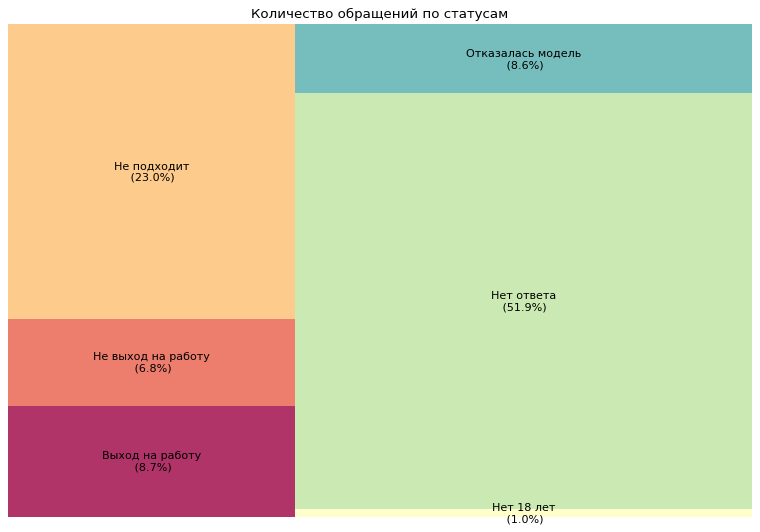

In [ ]:
df_status = crm.groupby('Конечный статус').size().reset_index(name = 'counts')
labels = df_status.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(df_status['counts']) * 100, 1)) + "%)", axis=1)
sizes = df_status['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество обращений по статусам')
plt.axis('off')
plt.show()



*  Статус "Нет ответа" берет практически 52%. Этот статус выставляют, когда менеджерам заказчика не удалось связаться с пользователем, оставившим свои данные по любым причинам - сбрасывают звонки, не отвечают, абонент недоступен, не хотят продолжать общение на первоначальном этапе разговора.

Нужна стратегия по снижению количества таких обращений!
*   Статус "Не выход на работу" - прошедшее собеседование было успешным, собеседуемый выразил желание выйти на работу, но в дальнейшем под любым предлогом отказался.

6,8% таких обращений от общего количества, это область работы заказчика, возможно необходимо пересмотреть скрипт собеседования.
*   Статус "Нет 18 лет" занимает 1%, некритично, скорее всего фактор обмана системы со стороны несовершеннолетних пользователей.
Также кто-то из исполнителей на первоначальном этапе запуска канала мог некорректно выставить настройки кампании (аудитория 18+), а в дальнейшем этот баг пофиксили, но какое-то количество обращений было зафиксировано.

* Статусы "Не подходит" и "Отказалась модель" - отказ от работы с обеих сторон по каким-либо причинам, на данном этапе с этими контактами нет смысла работать, хотя "Отказалась модель" перспективны для дальнейшего ретаргета или повторного обращение через какое-то время.

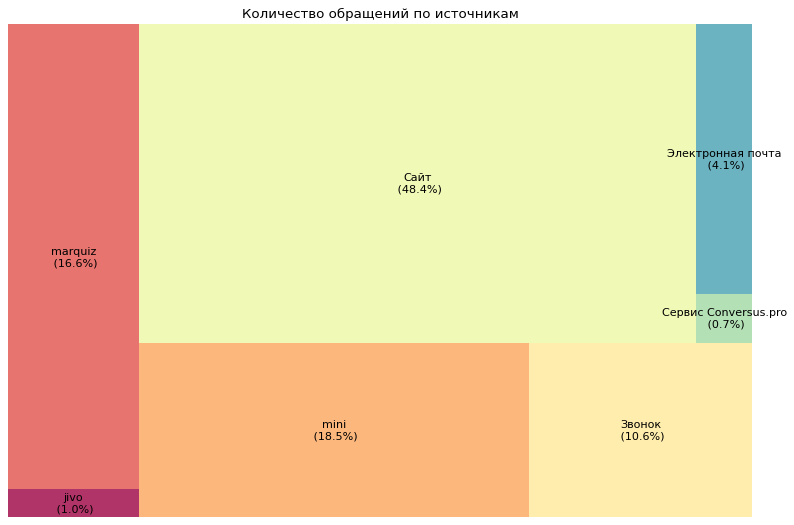

In [ ]:
df_source = crm.groupby('Источник').size().reset_index(name = 'counts')
labels = df_source.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(df_source['counts']) * 100, 1)) + "%)", axis = 1)
sizes = df_source['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество обращений по источникам')
plt.axis('off')
plt.show()

* Сервисы jivo и conversus установлены на основном сайте, все вместе эти три источника дают половину всех первичных обращений.
* Минилендинг и квиз марквиз на отдельных доменах вместе дают одну треть всех обращений, это хороший показатель для этого проекта, возможно, стоит развить эти направления.
* На телефонные звонки не делалась ставка при продвижении, основной призыв всех форм обратной связи - оставь контакты и наши менеджеры перезвонят тебе. Указанный номер телефона - одно из основных требований различных рекламных каналов. При этом каждое десятое обращение - именно по прямому звонку.
* Электронная почта дает небольшое количество обращений.

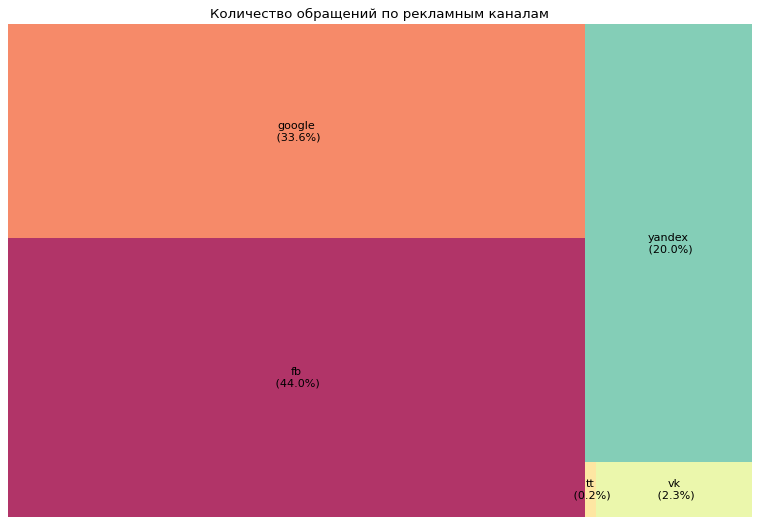

In [ ]:
df_channels = crm.groupby('Канал').size().reset_index(name = 'Всего обращений')
labels = df_channels.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(df_channels['Всего обращений']) * 100, 1)) + "%)", axis=1)
sizes = df_channels['Всего обращений'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество обращений по рекламным каналам')
plt.axis('off')
plt.show()

!
Здесь мы делаем скидку на то, что нам известны utm-метки рекламного канала только по 49% обращений, все выводы здесь и далее делаются на основе этих данных.!



* Отсуствуют метки MT совсем, в первую очередь необходимо проверить передачу данны именно из этого канала. Также VK и Tiktok

* Топ3 каналов по количеству обращений: fb, google, yandex. Контекст занимает больше половины всех обращений.



In [ ]:
# Перейдем к результативным обращениям (Выход на работу), посмотрим с каких площадок и каких каналов они приходили
result = crm[crm['Конечный статус'] == 'Выход на работу']

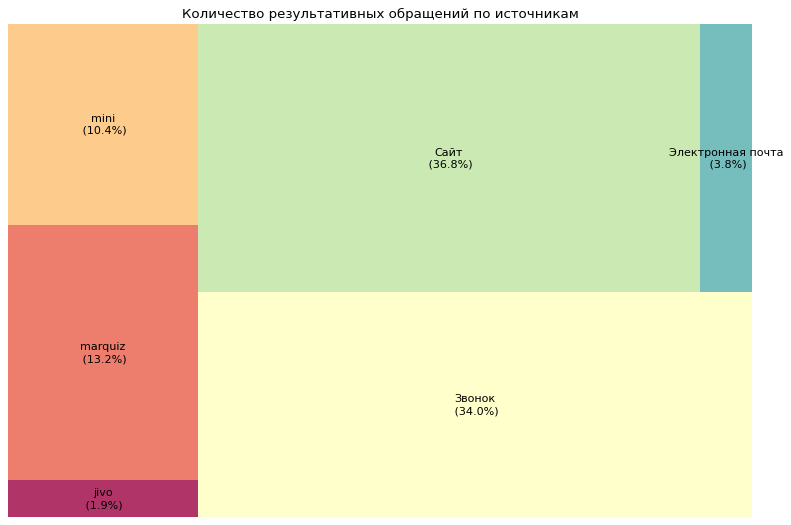

In [ ]:
result_source = result.groupby('Источник').size().reset_index(name = 'counts')
labels = result_source.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(result_source['counts']) * 100, 1)) + "%)", axis=1)
sizes = result_source['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество результативных обращений по источникам')
plt.axis('off')
plt.show()

* Треть выходов на работу была через звонок! Возможно, мы говорим здесь об активных людях, уже знакомых с работой и настроенных на работу. Стоит протестировать гипотезу с призывом к действию "позвонить" в креативах.
* Сервис Конверсус вообще не принес результата. Стоит пересмотреть его использование, возможно перенаправить расходы на него на другие площадки.
* Минилендинг и квиз на сторонних доменах совместно забирают четверть от результативных обращений, причем уменьшение доли в основном за счет минилендинга.

In [ ]:
#посмотрим, откуда приходили звонки
result_phone = result[result['Источник'] == 'Звонок']
result_phone

,ID,Конечный статус,Запись на собеседование,Источник,Дата создания,Канал
150,3896,Выход на работу,да,Звонок,2021-03-24 21:57:54,NaN
261,3540,Выход на работу,да,Звонок,2021-03-06 01:34:18,NaN
302,3408,Выход на работу,да,Звонок,2021-02-26 23:47:55,fb
305,3391,Выход на работу,да,Звонок,2021-02-26 00:59:05,NaN
310,3372,Выход на работу,да,Звонок,2021-02-25 00:29:08,NaN
322,3332,Выход на работу,да,Звонок,2021-02-23 20:48:41,NaN
325,3318,Выход на работу,да,Звонок,2021-02-22 21:29:23,fb
341,3250,Выход на работу,да,Звонок,2021-02-20 21:17:13,NaN
364,3170,Выход на работу,да,Звонок,2021-02-17 16:24:06,NaN
382,3116,Выход на работу,да,Звонок,2021-02-15 23:01:12,NaN


Важно настроить сквозную аналитику по звонкам - данных практически нет

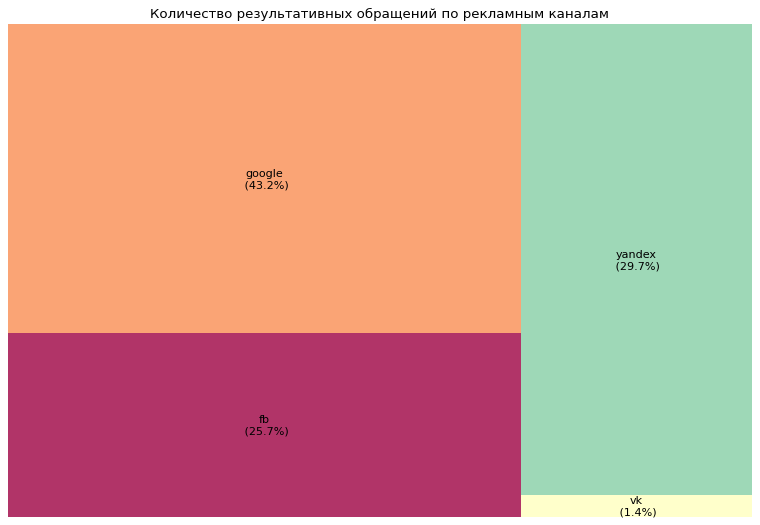

In [ ]:
result_channels = result.groupby('Канал').size().reset_index(name = 'Выходы на работу')
labels = result_channels.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(result_channels['Выходы на работу']) * 100, 1)) + "%)", axis=1)
sizes = result_channels['Выходы на работу'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество результативных обращений по рекламным каналам')
plt.axis('off')
plt.show()

* В топ3 каналов входят те же самые, но вот их порядок совсем другой: google, yandex, fb. У fb большая разница между общим числом обращений и выходами на работу.

In [ ]:
#Построим воронку по ключевым точкам: обращения -> запись на собеседования  -> выходы на работу для всей выборки
stages = ['Обращения всего', 'Запись на собеседование', 'Выход на работу']
values = [crm.shape[0], crm['Запись на собеседование'].value_counts()['да'], crm['Конечный статус'].value_counts()['Выход на работу']]

fig = px.funnel(y = stages, x = values, title ='Воронка выходов на работу на первом этапе',)
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
# посмотрим подробнее на обращения со статусом Нет ответа, основные источники и каналы
no_answer = crm[crm['Конечный статус'] == 'Нет ответа']

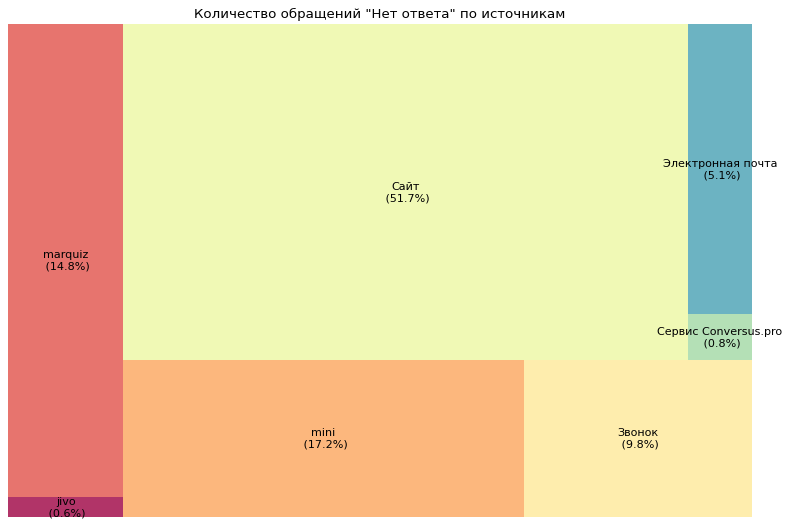

In [ ]:
no_answer_source = no_answer.groupby('Источник').size().reset_index(name = 'counts')
labels = no_answer_source.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(no_answer_source['counts']) * 100, 1)) + "%)", axis=1)
sizes = no_answer_source['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество обращений "Нет ответа" по источникам')
plt.axis('off')
plt.show()

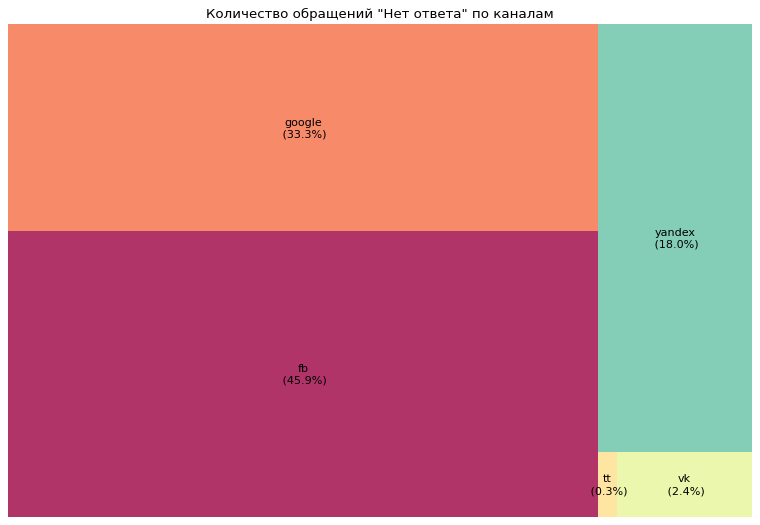

In [ ]:
no_answer_channels = no_answer.groupby('Канал').size().reset_index(name = 'counts')
labels = no_answer_channels.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1] / sum(no_answer_channels['counts']) * 100, 1)) + "%)", axis=1)
sizes = no_answer_channels['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize = (12,8), dpi = 80)
squarify.plot(sizes = sizes, label = labels, color = colors, alpha = .8)

plt.title('Количество обращений "Нет ответа" по каналам')
plt.axis('off')
plt.show()

Никаких сюрпризов нет, распределение примерно такое же, как и у главной выборки в целом. Соответственно, стратегия по изменению количества "мусорных" лидов касается всех рекламных каналов. Тогда проверим гипотезу, что лиды Нет ответа приходят по ночам, примерно в одно и тоже время.

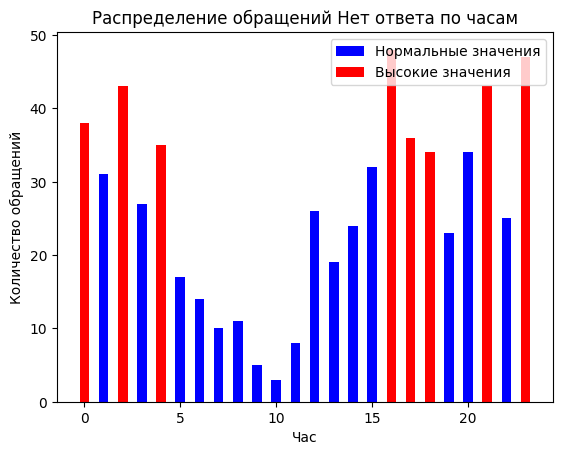

In [ ]:
no_answer['Время'] = no_answer['Дата создания'].dt.time
no_answer['Время'] = pd.to_datetime(no_answer['Время'], format='%H:%M:%S')
no_answer = no_answer.assign(Час=no_answer['Время'].dt.hour)


leads_by_hour = no_answer['Час'].value_counts()

plt.bar(leads_by_hour.index, leads_by_hour.values, width=0.5, color='#0000FF')

# Выделяем топ 8 значений красным цветом
for i in leads_by_hour.index[:8]:
    plt.bar(i, leads_by_hour.loc[i], width=0.5, color='#FF0000')

plt.title('Распределение обращений "Нет ответа" по часам')
plt.xlabel('Час')
plt.ylabel('Количество обращений')
plt.legend(['Нормальные значения', 'Высокие значения'], loc='upper right')
plt.show()

* Из неожиданного - большое количество лидов Нет ответа отправлены в 16-19 часов.

## Показатели рекламных каналов и расчет юнит-экономики

В нашем случае расчет будет простым, затраты на сервисы мы разделим на все каналы равномерно, затраты на специалистов мы отнесем к кажому каналу. При этом специалисты по контексту в какой-то момент работали над двумя каналами - google и yandex, поэтому эти расходы делим пополам на каждый из каналов.

Итоговый бюджет по каналам посмотрим по всей воронке - от показов до выходов на работу.

In [ ]:
costs

,Сумма,Назначение,Отчетный период
0,1200,service_costs,октябрь
1,15075,fb,октябрь
2,3475,service_costs,октябрь
3,610,service_costs,октябрь
4,390,service_costs,октябрь
...,...,...,...
127,10000,контекст,апрель
128,1000,service_costs,апрель
129,990,service_costs,апрель
130,200,service_costs,апрель


In [ ]:
# сначала займемся зарплатой специалистов по контексту, чтобы она корректно отображалась для каждого канала
sum_kontekst = costs[costs['Назначение'] == 'контекст']['Сумма'].sum()
costs = costs.append({'Сумма': (sum_kontekst / 2), 'Назначение': 'yandex'}, ignore_index=True)
costs = costs.append({'Сумма': (sum_kontekst / 2), 'Назначение': 'google'}, ignore_index=True)
# Удаляем строки со значением контекст из датафрейма
costs = costs.loc[costs['Назначение'] != 'контекст']

<ipython-input-170-9fdf3dea0e0a>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-170-9fdf3dea0e0a>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
#далее выделим все расходы на сервисы и посчитаем их сумму для дальнейших расчетов
df_service_costs = costs[costs['Назначение'] == 'service_costs']
sum_service_costs = df_service_costs['Сумма'].sum()
# удаляем эти значения из основного дф
costs = costs.drop(df_service_costs.index)

In [ ]:
costs_all = costs.groupby(['Назначение']).agg({'Сумма': 'sum'})
costs_all

,Сумма
Назначение,
fb,129305.0
google,113882.5
mt,20000.0
tt,20000.0
vk,13925.0
yandex,80042.5


In [ ]:
channels_all = channels.groupby(['Канал']).agg({
    'Расходы': 'sum',
    'Показы': 'sum',
    'Клики': 'sum'
})
channels_all

,Расходы,Показы,Клики
Канал,,,
fb,485552.25,1083093,20085
google,487832.95,932297,6374
mt,69292.94,723720,3515
tt,48813.25,855672,3307
vk,60789.38,2159823,2606
yandex,259687.26,1884344,11842


In [ ]:
unit = pd.concat([channels_all, costs_all], axis=1)
unit['Канал'] = ['fb', 'google', 'mt', 'tt', 'vk', 'yandex']
unit = unit.reset_index(drop=True)
unit

,Расходы,Показы,Клики,Сумма,Канал
0,485552.25,1083093,20085,129305.0,fb
1,487832.95,932297,6374,113882.5,google
2,69292.94,723720,3515,20000.0,mt
3,48813.25,855672,3307,20000.0,tt
4,60789.38,2159823,2606,13925.0,vk
5,259687.26,1884344,11842,80042.5,yandex


In [ ]:
unit['Итог расход'] = (unit['Расходы'] + unit['Сумма'] + (sum_service_costs / len(unit))).round(2)
unit

,Расходы,Показы,Клики,Сумма,Канал,Итог расход
0,485552.25,1083093,20085,129305.0,fb,636748.42
1,487832.95,932297,6374,113882.5,google,623606.62
2,69292.94,723720,3515,20000.0,mt,111184.11
3,48813.25,855672,3307,20000.0,tt,90704.42
4,60789.38,2159823,2606,13925.0,vk,96605.55
5,259687.26,1884344,11842,80042.5,yandex,361620.93


In [ ]:
unit = unit.drop(unit.columns[[0, 3]], axis= 1)

In [ ]:
#добавим расчет метрик
unit['CPM, руб'] = (unit['Итог расход'] / unit['Показы'] * 1000).round(2)
unit['CPC, руб'] = (unit['Итог расход'] / unit['Клики']).round(2)
unit['CTR, %'] = (unit['Клики'] / unit['Показы'] * 100).round(2)

unit = unit[['Канал', 'Итог расход', 'Показы', 'CPM, руб', 'Клики', 'CPC, руб', 'CTR, %']]
unit

,Канал,Итог расход,Показы,"CPM, руб",Клики,"CPC, руб","CTR, %"
0,fb,636748.42,1083093,587.90,20085,31.70,1.85
1,google,623606.62,932297,668.89,6374,97.84,0.68
2,mt,111184.11,723720,153.63,3515,31.63,0.49
3,tt,90704.42,855672,106.00,3307,27.43,0.39
4,vk,96605.55,2159823,44.73,2606,37.07,0.12
5,yandex,361620.93,1884344,191.91,11842,30.54,0.63


* Самые дешевые показы у VK, при этом CTR самый низкий, а стоимость клика средняя, как у других каналов.
* Самые дорогие показы у google, выше стоимости показов fb на 81 руб, и в 3.5 раза выше стоимости показов yandex, не говоря уже о показах в остальных каналах
* Также у google самая высокая (выше остальных каналов в 3 с лишним раза!) цена клика и средний ctr.
* MyTarget выглядит перспективным по стоимости 1000 показов и клика, нужны дополнительные исследования после настройки корректной передачи utm-меток.


In [ ]:
#присоедним датафрейм из предыдущих расчетов, чтобы посмотреть стоимость 1 первичного обращения по каналам за весь период
unit = unit.merge(df_channels, on = 'Канал', how = 'left')
unit['Конверсия клики в обращения'] = (unit['Всего обращений'] / unit['Клики'] * 100).round(2)
unit['Стоимость первич обращения'] = (unit['Итог расход'] / unit['Всего обращений']).round(2)
unit

,Канал,Итог расход,Показы,"CPM, руб",Клики,"CPC, руб","CTR, %",Всего обращений,Конверсия клики в обращения,Стоимость первич обращения
0,fb,636748.42,1083093,587.90,20085,31.70,1.85,262.0,1.30,2430.34
1,google,623606.62,932297,668.89,6374,97.84,0.68,200.0,3.14,3118.03
2,mt,111184.11,723720,153.63,3515,31.63,0.49,NaN,NaN,NaN
3,tt,90704.42,855672,106.00,3307,27.43,0.39,1.0,0.03,90704.42
4,vk,96605.55,2159823,44.73,2606,37.07,0.12,14.0,0.54,6900.40
5,yandex,361620.93,1884344,191.91,11842,30.54,0.63,119.0,1.00,3038.83


* Самое дорогое первичное обращение у ТикТока, но мы знаем, что есть проблема с передачей меток, плюс этот канал не получилось запустить полноценно, поэтому этот показатель мы опускаем.
* 6,9 тыс рублей за первичное обращение от ВК, может влиять как проблема с передачей меток, так и отражать реальность.
* Три остальных канала имеют относительно равную стоимость первичного обращения.
* Отличная конверсия кликов в обращения у google, неплохой показатель у fb и yandex, на уровне ожидаемого.

In [ ]:
# конверсия клики в первыичные обращения
cr_click_lead = round(crm.shape[0] / unit['Клики'].sum() * 100, 2)
cr_click_lead

2.56

In [ ]:
#создадим датафрейм, чтобы посмотреть количество записей на собеседование, присоединим к рассчитываемому дф и посчитаем стоимость 1 записи
df_interview = crm[crm['Запись на собеседование'] == 'да']
interview_channels = df_interview.groupby('Канал').size().reset_index(name = 'Записи на собеседование')

unit = unit.merge(interview_channels, on = 'Канал', how = 'left')

unit['Стоимость записи на собеседование'] = (unit['Итог расход'] / unit['Записи на собеседование']).round(2)
unit

,Канал,Итог расход,Показы,"CPM, руб",Клики,"CPC, руб","CTR, %",Всего обращений,Конверсия клики в обращения,Стоимость первич обращения,Записи на собеседование,Стоимость записи на собеседование
0,fb,636748.42,1083093,587.90,20085,31.70,1.85,262.0,1.30,2430.34,99.0,6431.80
1,google,623606.62,932297,668.89,6374,97.84,0.68,200.0,3.14,3118.03,84.0,7423.89
2,mt,111184.11,723720,153.63,3515,31.63,0.49,NaN,NaN,NaN,NaN,NaN
3,tt,90704.42,855672,106.00,3307,27.43,0.39,1.0,0.03,90704.42,1.0,90704.42
4,vk,96605.55,2159823,44.73,2606,37.07,0.12,14.0,0.54,6900.40,3.0,32201.85
5,yandex,361620.93,1884344,191.91,11842,30.54,0.63,119.0,1.00,3038.83,46.0,7861.32


* Стоимость 1 записи на собеседование примерно пропорционально у трех основных каналов, при этом fb на этом этапе более выгоден.
* Показатель ВК слишком дорогой.

In [ ]:
#присоедним датафрейм из предыдущих расчетов, чтобы посмотреть стоимость 1 выхода на работу по каналам за весь период
unit = unit.merge(result_channels, on = 'Канал', how = 'left')
unit['Стоимость выхода на работу'] = (unit['Итог расход'] / unit['Выходы на работу']).round(2)

unit

,Канал,Итог расход,Показы,"CPM, руб",Клики,"CPC, руб","CTR, %",Всего обращений,Конверсия клики в обращения,Стоимость первич обращения,Записи на собеседование,Стоимость записи на собеседование,Выходы на работу,Стоимость выхода на работу
0,fb,636748.42,1083093,587.90,20085,31.70,1.85,262.0,1.30,2430.34,99.0,6431.80,19.0,33513.07
1,google,623606.62,932297,668.89,6374,97.84,0.68,200.0,3.14,3118.03,84.0,7423.89,32.0,19487.71
2,mt,111184.11,723720,153.63,3515,31.63,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt,90704.42,855672,106.00,3307,27.43,0.39,1.0,0.03,90704.42,1.0,90704.42,NaN,NaN
4,vk,96605.55,2159823,44.73,2606,37.07,0.12,14.0,0.54,6900.40,3.0,32201.85,1.0,96605.55
5,yandex,361620.93,1884344,191.91,11842,30.54,0.63,119.0,1.00,3038.83,46.0,7861.32,22.0,16437.31


* Как помним из графика выше, каналы распределяются по показателю "Выходы на работу" следующим образом: google, yandex, fb. По стоимости выхода на работу Яндекс.Директ оказывается более выгодным чем Google.Adsense.
* 1 выход на работу от Fb обходится в два с лишним раза дороже чем выход от яндекса. Это опровергает первичную гипотезу специалистов по приоритету этого канала, хотя первоначальные показатели стоимости в воронке выглядели привлекательно.
* Высокая стоимость показов и кликов у google в итоге приводит к самому высокому показателю по выходам на работу, при этом их стоимость на 14 тыс дешевле чем у fb.

In [ ]:
# средняя стоимость выхода на работу в целом за первый этап
all_result = round(unit['Итог расход'].sum() / crm['Конечный статус'].value_counts()['Выход на работу'], 0)
all_result

18118.0

In [ ]:
stages2 = ['Стоимость первичного обращения', 'Стоимость записи на собеседование', 'Стоимость выхода на работу']

yandex_data = unit[unit['Канал'] == 'yandex']
yandex_list = [yandex_data['Стоимость первич обращения'].iloc[0],
               yandex_data['Стоимость записи на собеседование'].iloc[0],
               yandex_data['Стоимость выхода на работу'].iloc[0]]


google_data = unit[unit['Канал'] == 'google']
google_list = [google_data['Стоимость первич обращения'].iloc[0],
               google_data['Стоимость записи на собеседование'].iloc[0],
               google_data['Стоимость выхода на работу'].iloc[0]]


fb_data = unit[unit['Канал'] == 'fb']
fb_list = [fb_data['Стоимость первич обращения'].iloc[0],
           fb_data['Стоимость записи на собеседование'].iloc[0],
           fb_data['Стоимость выхода на работу'].iloc[0]]


fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Yandex',
    orientation = 'h',
    y = stages2,
    x = yandex_list,
    textinfo = 'value'))

fig.add_trace(go.Funnel(
    name = 'Google',
    orientation = 'h',
    y = stages2,
    x = google_list,
    textinfo = 'value'))

fig.add_trace(go.Funnel(
    name = 'FB',
    orientation = 'h',
    y = stages2,
    x = fb_list,
    textinfo = 'value'))

fig.update_layout(title ='Сравнение стоимости 1 лида в воронке по разным рекламным каналам', title_x=0.5)

fig.show()

* Приоритет на следующий этап - контекст, оба канала google и yandex показывают хорошие результаты по количеству выходов на работу и по их стоимости.



### FB

In [ ]:
costs_all

,Сумма
Назначение,
fb,129305.0
google,113882.5
mt,20000.0
tt,20000.0
vk,13925.0
yandex,80042.5


In [ ]:
#Построим воронку по ключевым точкам: обращения -> запись на собеседования  -> выходы на работу для канала FB
values_fb = [fb_data['Всего обращений'].iloc[0], fb_data['Записи на собеседование'].iloc[0], fb_data['Выходы на работу'].iloc[0]]

fig = px.funnel(y = stages, x = values_fb, title ='Воронка выходов на работу для канала FB',)
fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
fb_result = round(fb_data['Выходы на работу'].iloc[0] / fb_data['Всего обращений'].iloc[0] * 100, 1)
fb_result

7.3

* FB требует пересмотра подхода к рекламным кампаниям, при хороших показателях первых двух этапов воронки по сравнению с двумя другими основными каналами, конверсия в выходы на работу ниже средней по всем обращениям. При этом расходы на косты у этого канала самые высокие за весь период, и сравнимый бюджет с google на саму рекламную кампанию.

# Выводы и рекомендации

На основании анализа имеющихся данных можно сделать следующие выводы:
* На первом этапе некорректно настроена передача utm-меток, что несколько ограничило в выводах и поисках инсайтов. Необходима новая система utm-меток, полноценная сквозная аналитика, включающая анализ прямых звонков.
* Первоначальные гипотезы специалистов по выбранным рекламных каналам, а также призывам к действию оказались частично ошибочными. Необходимо пересмотреть первоначальную разработку креативной стратегии и скорректировать её с учетом этого исследования.
* Контекстные рекламные системы для этого проекта будут приоритетными и позволят держать стоимость 1 выхода на работу на уровне до 20 тыс рублей.  Google показывает лучшие результаты, yandex дешевле по воронке, имеет поле для экспериментов.
* Facebook/Instagram имеет хорошие показатели на первоначальной воронке. Нужна смена тактики по этому каналу для снижения средней стоимости выхода на работу. Если приблизиться к показателям контекста не получится, то стоит отказаться от этого канала и перенаправить бюджеты.
* MyTarget выглядит интересным направлением по первичным метрикам. Нужны дополнительные тесты по этому каналу после внедрения коррекции сбора данных.
* По VK также рекомендуется провести тесты. Если метрики будут такими, же как в данном исследовании,  тогда от канала стоит отказаться и перераспределить бюджеты в пользу других.
